In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import math

import numpy as np
import datetime
from IPython.display import display
import pandas as pd

from garmindb import ConfigManager
from garmindb.garmindb import GarminSummaryDb, DaysSummary, MonitoringDb, MonitoringHeartRate, Sleep
from garmindb.summarydb import DaysSummary, SummaryDb
from garmindb.garmindb import GarminSummaryDb, YearsSummary

from jupyter_funcs import format_number
from graphs import Graph

In [24]:
def minsFromTime(t):
    return float(t.hour * 3600 + t.minute * 60 + t.second) / 60.0

In [25]:
# start date
start_ts = datetime.datetime.combine(datetime.date(year=2024, month=2, day=19), datetime.datetime.min.time())
# end date (today)
end_ts = datetime.datetime.combine(datetime.date.today(), datetime.datetime.max.time())

db_params = ConfigManager.get_db_params()
garmin_db = GarminDb(db_params)
sum_db = SummaryDb(db_params, False)
data = DaysSummary.get_for_period(sum_db, start_ts, end_ts, DaysSummary)
sleep = Sleep.get_for_period(garmin_db, start_ts, end_ts)

time = [entry.day for entry in data]

In [26]:
stress_avg = [entry.stress_avg for entry in data]
bb_max = [entry.bb_max for entry in data]
bb_min = [entry.bb_min for entry in data]
spo2_avg = [entry.spo2_avg for entry in data]
dm_df = pd.DataFrame([time, stress_avg, bb_max, bb_min, spo2_avg]).T
dm_df.columns = ["Date", "stress_avg", "bb_max", "bb_min", "spo2_avg"]
# remove the last record 'cause it's noisy sometimes
dm_df.drop(dm_df.tail(1).index,inplace=True) 
dm_df



,Date,stress_avg,bb_max,bb_min,spo2_avg
0,2024-02-20,33,60,17,91.0
1,2024-02-21,39,48,5,89.0
2,2024-02-22,44,41,5,92.0
3,2024-02-23,34,31,5,91.0
4,2024-02-24,28,73,13,91.0
5,2024-02-25,31,63,5,91.0
6,2024-02-26,27,54,7,90.0
7,2024-02-27,37,69,5,91.0
8,2024-02-28,29,36,5,90.0
9,2024-02-29,40,44,5,89.0


In [28]:
years_to_display = 4
days_to_display = (years_to_display * 365)


years_data = []
current_year = datetime.date.today().year
for year in range(current_year - years_to_display, current_year + 1):
    year_data = YearsSummary.get_year(sum_db, year)
    years_data.append([year, format_number(year_data.rhr_avg), format_number(year_data.rhr_min), format_number(year_data.rhr_max),
                       format_number(year_data.hr_avg), format_number(year_data.hr_min), format_number(year_data.hr_max)])

doc = snakemd.new_doc()
doc.add_heading("Heart Rate", 3)
doc.add_table(['Year', 'Avg Resting HR', 'Min Resting HR', 'Max Resting HR', 'Avg HR', 'Min HR', 'Max HR'], years_data)
display(Markdown(str(doc)))
graph.graph_activity('hr', days=days_to_display)

AttributeError: 'NoneType' object has no attribute 'rhr_avg'

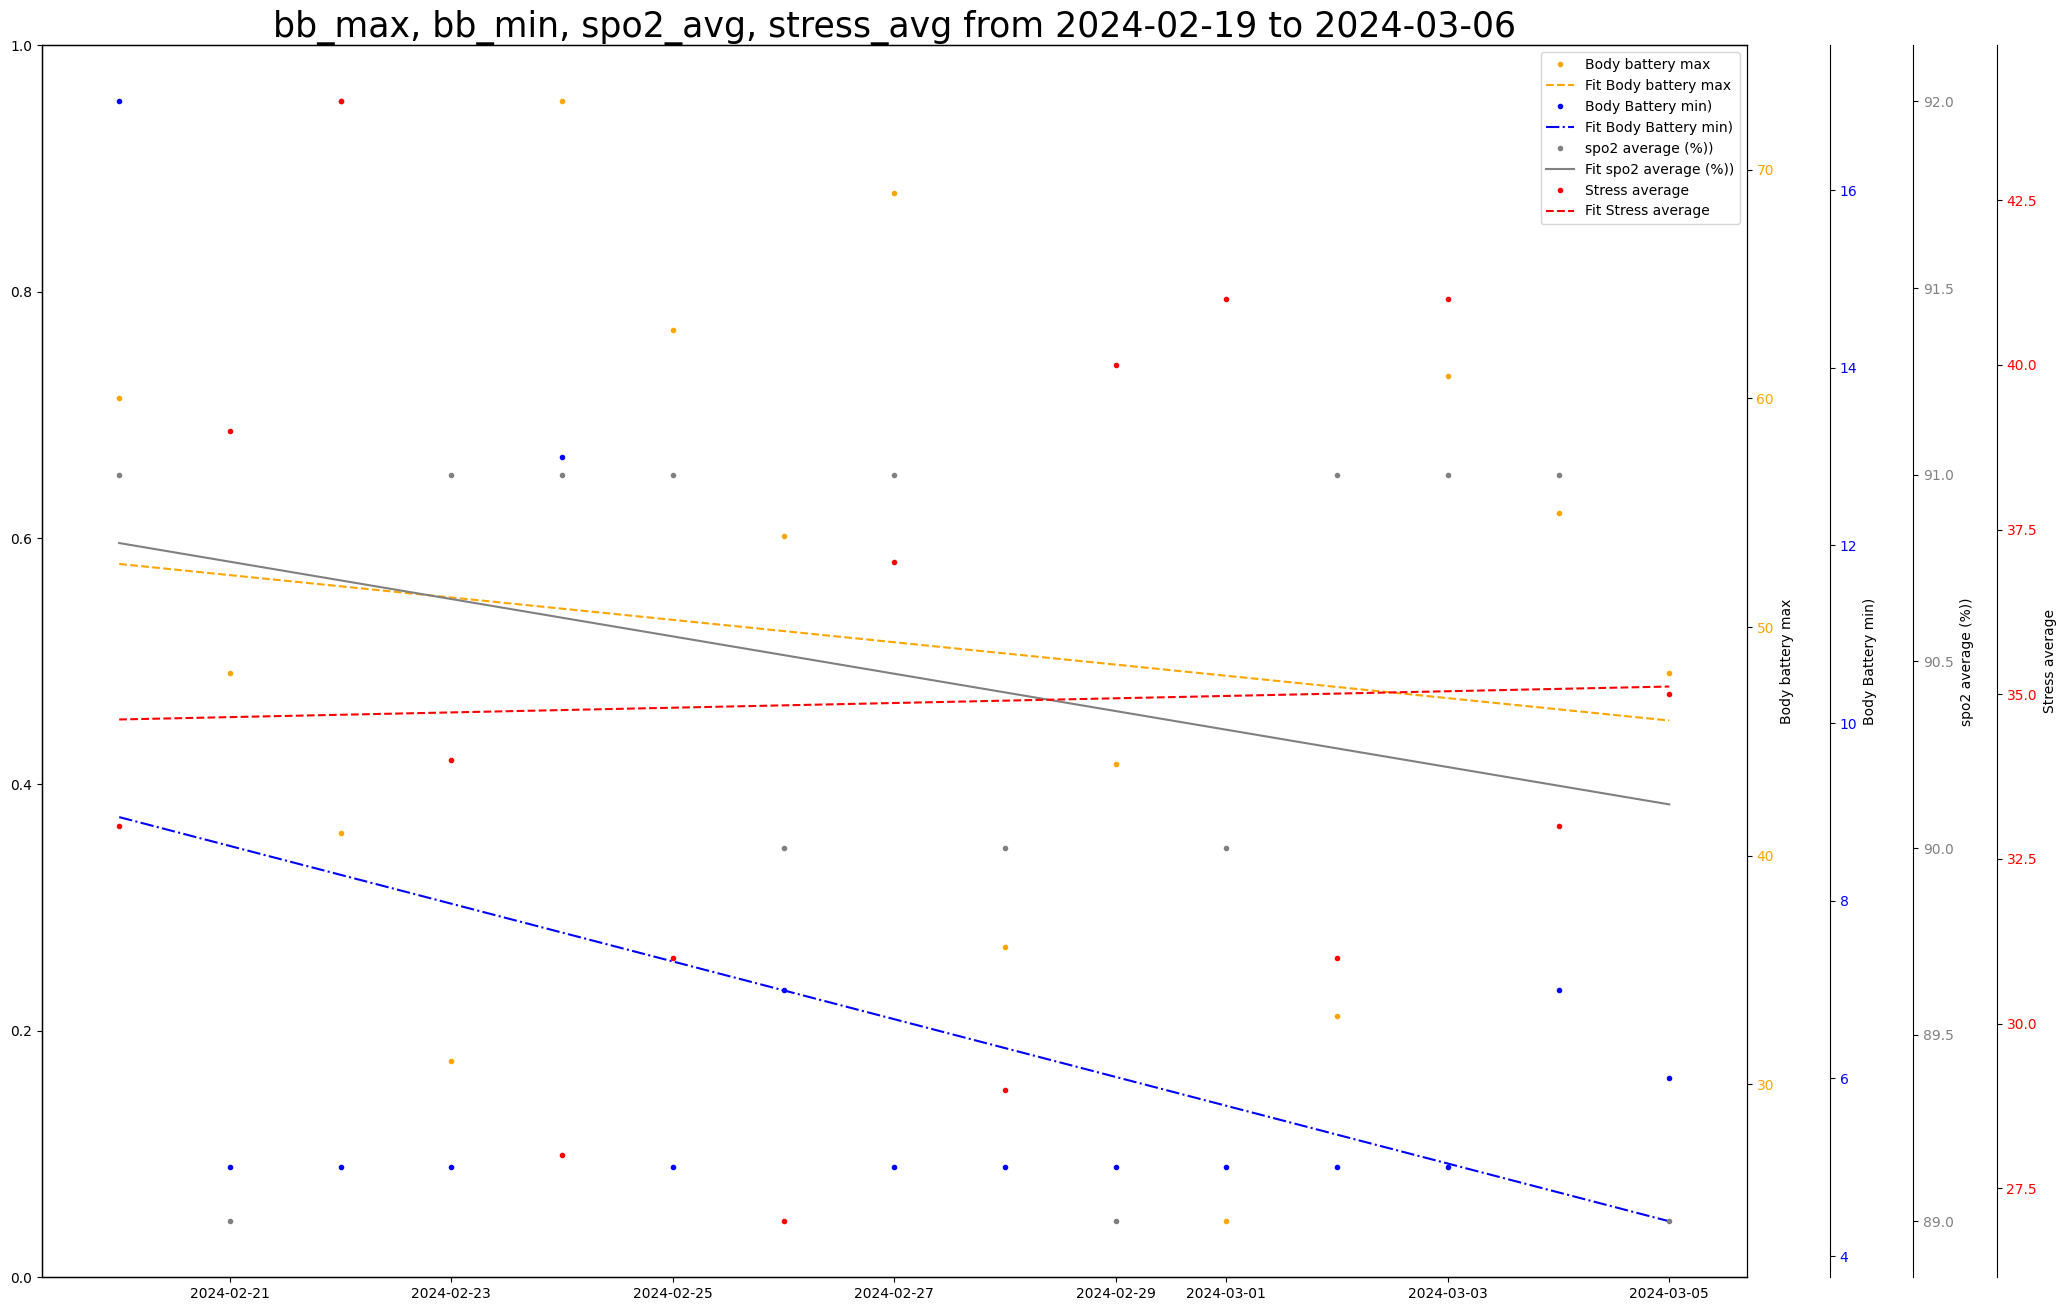

,,min,max
0,Fit Body battery max,45.908333,52.758333
1,Fit Body Battery min),4.391667,8.941667
2,Fit spo2 average (%)),90.116667,90.816667
3,Fit Stress average,34.616667,35.116667


In [16]:


columns = { "stress_avg" : 
                   {
                       "label": "Stress average",
                       "trend_marker": "--",
                       "color": "red"

                   }, 
            "bb_max": 
                   {
                       "label": "Body battery max",
                       "trend_marker": "--",
                       "color": "orange"
                   },
           
            "bb_min": 
                   {
                       "label": "Body Battery min)",
                       "trend_marker": "-.",
                       "color": "blue"
                  },
             "spo2_avg": 
                   {
                       "label": "spo2 average (%))",
                       "trend_marker": "-",
                       "color": "grey"
                   }
          }

# these are the data columns to plot
show_cols = {"stress_avg", "bb_max", "bb_min",  "spo2_avg"}

fig, host = plt.subplots(figsize=(22,16))

plots = []
fit_summary = []
step = 0

for col in show_cols:
    label=columns[col]["label"]
   
    ax2 = host.twinx()
    ax2.set_ylabel(label)
    ax2.tick_params(axis='y', labelcolor=columns[col]["color"])

    # data
    plot, = ax2.plot(dm_df.Date, dm_df[col], 'o', ms=3.0, color=columns[col]["color"], label=label)
    plots.append(plot)
    
    # trend
    fitlabel = 'Fit {}'.format(label)
    x_dates = dates.date2num(dm_df.Date)
    trend = np.polyfit(x_dates, dm_df[col].astype(float) , 1)
    fit = np.poly1d(trend)
    x_fit = np.linspace(x_dates.min(), x_dates.max())
    fit, = ax2.plot(dates.num2date(x_fit), fit(x_fit), linestyle=columns[col]["trend_marker"], color=columns[col]["color"],label=fitlabel)
    plots.append(fit)
    
    ax2.spines['right'].set_position(('outward', step))
    
    step = step + 60

    fit_data = fit.get_ydata()
    
    fit_summary.append({"": fitlabel, "min": fit_data.min(), "max":fit_data.max()})
    
host.legend(handles=plots, loc='best')

col_label = ""
for col in show_cols:
    if len(col_label):
        col_label += ", "
    col_label += f"{col}"

title = f"{col_label} from {start_ts.date()} to {end_ts.date()}"

plt.title(label=title, fontsize=25)

plt.show()
pd.DataFrame(fit_summary)